<a href="https://colab.research.google.com/github/guilhermessc/Pair-Trading/blob/master/Pair_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<h1><center>
Pair Trading and Profit Analysis

**Guilherme Sales Santa Cruz**

Université Paris-Saclay

Scientific Programming - Final Project

*October 2020*

<br>

---

<br>

Database: Yahoo Finance

<br>

---



<br>
</center></h1>

# Introduction

This notebook will be used to implement a **pair trading** strategy. This is a **classic algorithmic strategy** for traders who want to **avoid the market risk** *i.e.* price variations caused the correlation among the companies in the stock market. It is possible to observe these fluctuations using the market benchmarks e.g. S&P500 for the US or Ibovespa for Brazil.

## Pair Trading

The idea behind this technique is to profit on the oscilations of relative growth between two companies.

In practice, the trader owns two [positions](https://www.investopedia.com/ask/answers/100314/whats-difference-between-long-and-short-position-market.asp) simultaneously: a long position ("buy") in one of the companies and a short position ("sell") in the other. Then, based on the historical information he switches or quits these positions according to his parameters.

## Tools

For this implementation I will use **Yahoo Finance API** to recover the data, **pandas** to read the tabular data, **statsmodels** for statistics methods and **matplotlib/seaborn** to display the results.


## Summary

This project will be divided in:
1. Recover the data
2. Find a Pair
3. Define a strategy
4. Evaluate the strategy


In [ ]:
# The following lines install the necessary libraries

!pip install yfinance
!pip install pandas-datareader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pandas_datareader import data as pdr
import yfinance as yf
# Use yf over pdr
yf.pdr_override()

from statsmodels.tsa.stattools import coint

     |████████████████████████████████| 5.5MB 3.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=c665882addb34539a873568b19dce0974886b3375dce708f137a288f4892c8f0
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Recovering the data

To recover the data I will use **Yahoo Finance API** through **pandas_datareader** module.

For this project I will perform the strategy over some pre-selected companies, since performing over the whole market portfolio would be computationally expensive and beyond the objectives of this project.

Here is the list of the companies:
- Adobe (ADBE)
- Amazon (AMZN)
- Apple (AAPL)
- Berkshire Hathaway (BERK)
- Coca-Cola (KO)
- Facebook (FB)
- IBM (IBM)
- Microsoft (MSFT)
- Netflix (NFLX)
- Tesla (TSLA)

Notice that most of the companies are from the technology sector. I made this choice on purpose to compare the results when picking the pairs.

In [ ]:
# Lets create a class to manage the data
class Stocks:
  def __init__(self):
    self.dic = {}
    
  def add(self, ticker, data):
    self.dic[ticker] = data

  def get_data(self, ticker):
    return self.dic[ticker]

  def __len__(self):
    return len(self.dic)

  @classmethod
  def help(cls):
    print("This class manages stock data")

Stocks.help()

This class manages stock data


In [ ]:
# Companies tickers list
ticker_list=['ADBE', 'AMZN', 'AAPL' , 'FB', 'IBM', 'MSFT', 'NFLX', 'TSLA', 'BERK' , 'KO']

# For reproducibility, I have decided to fix the observed period
start_date="2010-01-01"
end_date="2019-11-30"

# Create an instance the object
stocks = Stocks()

# Recover and store the data
for ticker in ticker_list:
  df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
  stocks.add(ticker, df)

# Observe a sample of the data
print(ticker)
df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
KO


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-22,52.959999,53.189999,52.750000,53.029999,51.294212,9113300
2019-11-25,53.279999,53.389999,52.770000,53.220001,51.478001,10963500
2019-11-26,53.310001,53.939999,53.220001,53.900002,52.135738,13219800
2019-11-27,53.930000,54.099998,53.599998,53.950001,52.184105,9595200
2019-11-29,53.700001,53.730000,53.220001,53.400002,52.037933,7222300


As observed, our data is a set of different tables. For each table the columns ``` [Open,	High,	Low,	Close,	Adj Close, Volume] ``` represent the negotiated prices (US$) of a particular company's shares on a given day and the number of negotiated shares in a day. 



*   ``` Open ``` : The price when the market opens.
*   ``` Close ``` : The price when the market closes.
*   ``` High ``` : The highest price of the day.
*   ``` Low ``` : The lowest price of the day.
*   ``` Adj Close ``` : The adjusted price of the day, computed after the market closes.
*   ``` Volume ``` : The number of negotiated shares in a day.


In several market analysis, the column ``` Adj Close ``` is often taken as the representative price of the day.

In [ ]:
# Explore a sample of the data
print(ticker)
df.describe()

KO


,Open,High,Low,Close,Adj Close,Volume
count,2495.000000,2495.000000,2495.000000,2495.000000,2495.000000,2.495000e+03
mean,40.323641,40.567098,40.082575,40.334463,33.805806,1.485391e+07
std,6.268178,6.302606,6.238480,6.270127,8.309350,6.572603e+06
min,25.110001,25.150000,24.735001,25.014999,16.925758,2.996300e+06
25%,37.155001,37.410000,36.879999,37.139999,28.784147,1.065620e+07
50%,41.099998,41.320000,40.840000,41.099998,34.043449,1.337110e+07
75%,44.500000,44.745001,44.235001,44.509998,39.623732,1.731040e+07
max,55.750000,55.919998,55.299999,55.770000,53.552990,9.896750e+07


In [ ]:
# Data composition
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2010-01-04 to 2019-11-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2495 non-null   float64
 1   High       2495 non-null   float64
 2   Low        2495 non-null   float64
 3   Close      2495 non-null   float64
 4   Adj Close  2495 non-null   float64
 5   Volume     2495 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 136.4 KB


# Find a Pair

The most common way of finding a pair for this kind of trading is by **cointegration** although some prefer to use PCA and analyse the first and second main components of the dataset.

## Cointegration and Correlation

Cointegration is slightly different from Correlation. Instead of checking how often they vary toghether, it assesses the relative stability of the distributions, in this case, the time-series.

AMZN
NFLX
0.004948589478770095



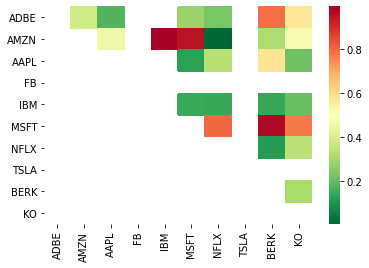

In [ ]:
n = len(stocks)

# Cointegration pairs matrix
coint_matrix = np.ones((n,n))

for t1 in range(n):
  # The column 'Adj Close' best represents the daily price
  stock1 = stocks.get_data(ticker_list[t1])['Adj Close']
  for t2 in range(t1+1,n):
    stock2 = stocks.get_data(ticker_list[t2])['Adj Close']
    
    try:
      # The smaller the p-value the more cointegrated two series are
      _ , pvalue, _ = coint(stock1, stock2)
    except:
      # Ignore if fails
      pvalue = 1
    coint_matrix[t1][t2] = pvalue

# Display graphically the cointegration matrix
sns.heatmap(coint_matrix,
            xticklabels=ticker_list, 
            yticklabels=ticker_list,
            cmap='RdYlGn_r',
            mask = (coint_matrix >= 0.9999))


pair_index_flattened = np.argmin(coint_matrix)
ticker1 = ticker_list[int(pair_index_flattened/n)]
print(ticker1)
ticker2 = ticker_list[pair_index_flattened%n]
print(ticker2)
print(np.min(coint_matrix))
print('')

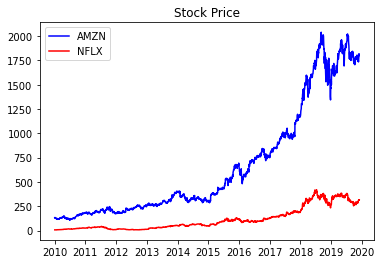

In [ ]:
# Get the best companies time series
ts1 = stocks.get_data(ticker1)['Adj Close']
ts2 = stocks.get_data(ticker2)['Adj Close']

# Plot the time series
plt.plot(ts1.index, ts1, label=ticker1, color='blue')
plt.plot(ts2.index, ts2, label=ticker2, color='red')
plt.title('Stock Price')
_ = plt.legend()

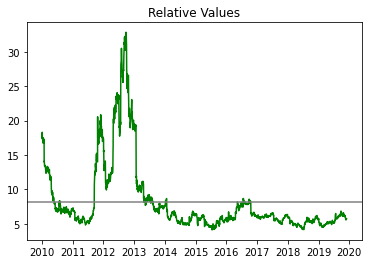

In [ ]:
# Visualize cointegration
relative_values = ts1/ts2

# Observe values oscilating near the average value
plt.plot(relative_values.index, relative_values, color='green')
plt.title('Relative Values')
_ = plt.axhline(np.mean(relative_values), color='grey')


There are major diferences in the past values of this time series but the most recent values are stable.

It is important to notice that cointegration of a time series is based on past data and I cannot affirm that this behaviour will repeat in the future.

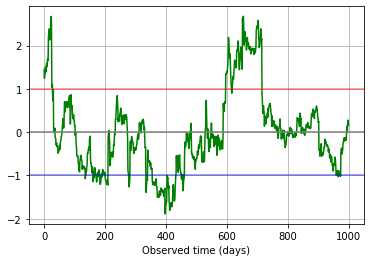

In [ ]:
# Visualize cointegration
relative_values = relative_values[-1500:-500]
mean = np.mean(relative_values)
xplot = np.linspace(0, 1000, len(relative_values))

# Observe values oscilating near the average value
plt.plot(xplot, relative_values-mean, color='green')
plt.axhline(0, color='grey')
plt.axhline(1, color='red', alpha=0.5)
plt.axhline(-1,color='blue', alpha=0.5)
plt.xlabel('Observed time (days)')
plt.grid()

In this graph, there is no sign of a trend and it oscilates around the mean as expected from cointegrated series.

## Pair Results

It seems that **Amazon** and **Netflix** are very likely to be cointegrated. I wonder why...

I will spare the reader from my speculations. For now, I would like to make some brief comments on the heatmap.

Facebook and Tesla results are not displayed in the heatmap. This is probably due to an error in the data that caused these two companies to be ignored when computing the cointegration matrix.

Additionally, despite being in different sectors, it is fair to say that Berkshire Hathaway and Coca-Cola had quite high cointegration values. However, a cautious trader would normally prefer to perform this strategy over same sectors companies for market protection.

# Define the Strategy

Observing the historical data in the previous graph, more precisely its peaks and stability, a good strategy would be to go long in Amazon and short in Netflix once the relative value differs in -1 from the average* and *vice-versa* when it differs in +1 always quiting the positions when it relative value crosses the average.

*Note that in the previous graph future values are used in the average. However, as the time-series are stationary it is fairly reasonable to choose the strategy parameters based on it.

## Beta Neutral Pair Trading

When setting the positions the trader must balance out the difference in value of each company share.

A naive strategy would be to balance out by quantity only. 

<br>

\begin{equation*}
n\_shares_{company\_a} * shares\_price_{company\_a} = n\_shares_{company\_b} * shares\_price_{company\_b}
\end{equation*}

<br>

That would be ok if both companies grew at the same rate. However in reality it doesn't happen.

A more sophisticated strategy would be to try to approximate a linear relatioship of both distributions.

<br>

\begin{equation*}
lin\_coef = argmin(error({x}*shares\_price_{company\_a} , shares\_price_{company\_b}))
\end{equation*}

<br>

\begin{equation*}
lin\_coef*n\_shares_{company\_a} * shares\_price_{company\_a} = n\_shares_{company\_b} * shares\_price_{company\_b}
\end{equation*}

<br>

That is actually a good method. Nonetheless, keeping in mind that the goal of this strategy is to reduce the market risk there is a financial indicator that was better designed to measure market risk, the [**Beta**](https://www.investopedia.com/terms/b/beta.asp) indicator. 

<br>

\begin{equation*}
\beta_a * n\_shares_{company\_a} * shares\_price_{company\_a} = \beta_b * n\_shares_{company\_b} * shares\_price_{company\_b}
\end{equation*}

<br>

This indicator is not hard to compute but it is subjective on how much historical** data one must observe to compute. Therefore, to avoid subjectivity I decided to take these values from yahoo* (*30th September 2020*):

- Beta [Amazon](https://finance.yahoo.com/quote/AMZN/key-statistics/): 1.32
- Beta [Netflix](https://finance.yahoo.com/quote/NFLX/key-statistics/): 0.97


*Yahoo uses monthly data over the past 5 years to compute these coeficients.

**Note that for a more rigorous out-of-time test I would need to compute the previous values of Beta. However, the oscilations of this indicator are negligible for these companies.

In [ ]:
# Set Beta variable
beta_amazon = 1.32
beta_netflix = 0.97

## Simulate the strategy

In [ ]:
# Initialize the variables

# Portfolio value over time
# It equals the total plus the position value
portfolio_value = []

# Current total
total = 0

position_encoding = {
0 : 'no positions',
1 : 'long on Amazon & short on Netflix',
2 : 'long on Netflix & short on Amazon'}
current_position = 0  # Starts with no positions
position_history = []

# Number of shares
n_amazon = 0 
n_netflix = 0

# Stock prices
ts1 = ts1[-1500:]
ts2 = ts2[-1500:]

# Relative values
relative_values = ts1/ts2

# Historical mean
mean = np.mean(relative_values[:-500])  # Spare 500 points for oot test

In [ ]:
# This function returns the numbers of shares to trade from each company
# In this case I will fix the number of Netflix's shares to 1000 and round up
#   the equivalent number of Amazon's shares to the closest int. 
def get_number_of_shares(time):
  ratio_amazon_netflix = ts2[time]/ts1[time] * beta_netflix/beta_amazon
  return np.rint(1000*ratio_amazon_netflix), 1000

The following script simulates a process that depends on its internal state at every given point in time.



```
For day in period:
  new_position = compute_position(stock_prices[day])
  if new_position != current_position:
    portfolio.update(new_position)
  
  total = portfolio.get_value(stock_prices[day])
  history.append((position, total))
  
```






In [ ]:
# Strategy simulation script
for i, rv in enumerate((relative_values-mean)):
  # If has position check if should quit
  if current_position == 1:
    # condition to quit long Amazon short Netflix
    if rv <= 0:
      total += ts1[i] * n_amazon
      total -= ts2[i] * n_netflix
      n_amazon = 0
      n_netflix = 0
      current_position = 0
  elif current_position == 2:
    # condition to quit long Netflix short Amazon
    if rv >= 0:
      total -= ts1[i] * n_amazon
      total += ts2[i] * n_netflix
      n_amazon = 0
      n_netflix = 0
      current_position = 0
  
  # If has no position check if should enter
  # Note that this allows to switch positions
  if current_position == 0:
    # condition to enter long Netflix short Amazon
    if rv >= 1:
      n_amazon, n_netflix = get_number_of_shares(i)
      total += ts1[i] * n_amazon
      total -= ts2[i] * n_netflix
      current_position = 2
    # condition to enter long Amazon short Netflix
    elif rv <= -1:
      n_amazon, n_netflix = get_number_of_shares(i)
      total -= ts1[i] * n_amazon
      total += ts2[i] * n_netflix
      current_position = 1

  # Register position
  position_history.append(current_position)

  # Compute current portfolio value 
  current_portfolio_value = total
  # If long Amazon short Netflix
  if current_position == 1:
    current_portfolio_value += n_amazon * ts1[i]
    current_portfolio_value -= n_netflix * ts2[i]
  # If long Netflix short Amazon
  elif current_position == 2:
    current_portfolio_value -= n_amazon * ts1[i]
    current_portfolio_value += n_netflix * ts2[i]
  # Register current portfolio value
  portfolio_value.append(current_portfolio_value)
    
print('Final portfolio value: %.2F' % portfolio_value[-1])

Final portfolio value: 164093.49


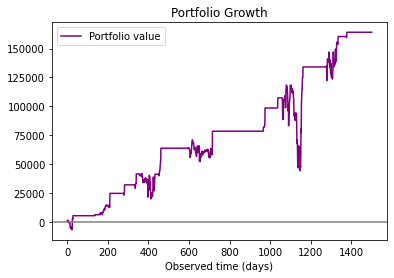

In [ ]:
# Plot results
xplot = np.linspace(0, 1500, 1500)
plt.plot(xplot, portfolio_value, color='purple', label='Portfolio value')
plt.axhline(0, color='grey')
plt.xlabel('Observed time (days)')
plt.title('Portfolio Growth')
_ = plt.legend()

# Results Evaluation

In this section I will analyse the returns of this strategy.

Note that I cannot compare the profits with the initially invested amount because this technique requires **no initial investment** but it has **unbounded loss potential**.

## Preliminary Observations


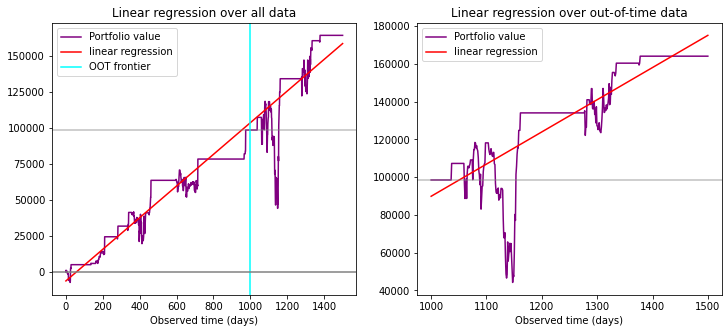

In [ ]:
plt.figure(figsize=(12,5))

# Compute linear regression over the portfolio
xplot = np.linspace(0, 1500, 1500)
a, b, _ , _ , _ = stats.linregress(xplot,portfolio_value)

# Plot left subplot
plt.subplot(121)
# Main curves
plt.plot(xplot, portfolio_value, color='purple', label='Portfolio value')
plt.plot(xplot, a*xplot+b, color='red', label='linear regression')
# Auxiliar lines
plt.axvline(1000, color='cyan', label='OOT frontier')
plt.axhline(0, color='grey')
plt.axhline(portfolio_value[1000], color='grey', alpha=0.5)
# Text
plt.title('Linear regression over all data')
plt.xlabel('Observed time (days)')
plt.legend()


# Compute linear regression over out of time data
xplot = np.linspace(1000, 1500, 500)
a, b, _ , _ , _ = stats.linregress(xplot,portfolio_value[-500:])

# Plot right subplot
plt.subplot(122)
# Main curves
plt.plot(xplot, portfolio_value[-500:], color='purple', label='Portfolio value')
plt.plot(xplot, a*xplot+b, color='red', label='linear regression')
# Auxiliar lines
plt.axhline(portfolio_value[1000], color='grey', alpha=0.5)
# Text
plt.title('Linear regression over out-of-time data')
plt.xlabel('Observed time (days)')
_ = plt.legend()


As observed both sets of data have a quite linear growing tendency despite the valley observed in the second one which will be further analyzed.

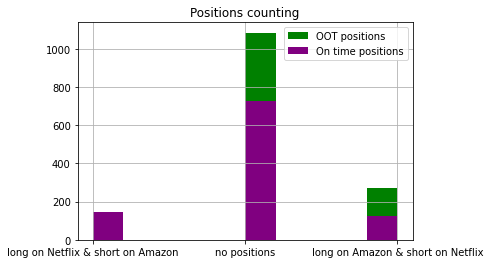

In [ ]:
# Display the total of each position
enconded_positions = [position_encoding[i] for i in position_history]
plt.hist(enconded_positions, color='green', label='OOT positions')
plt.hist(enconded_positions[:1000], color='purple', label='On time positions')
plt.title('Positions counting')
plt.grid()
_ = plt.legend()

Surprisingly, for a rather steady growth, most of the time the strategy held no positions.

## The Valleys in the Portfolio Value

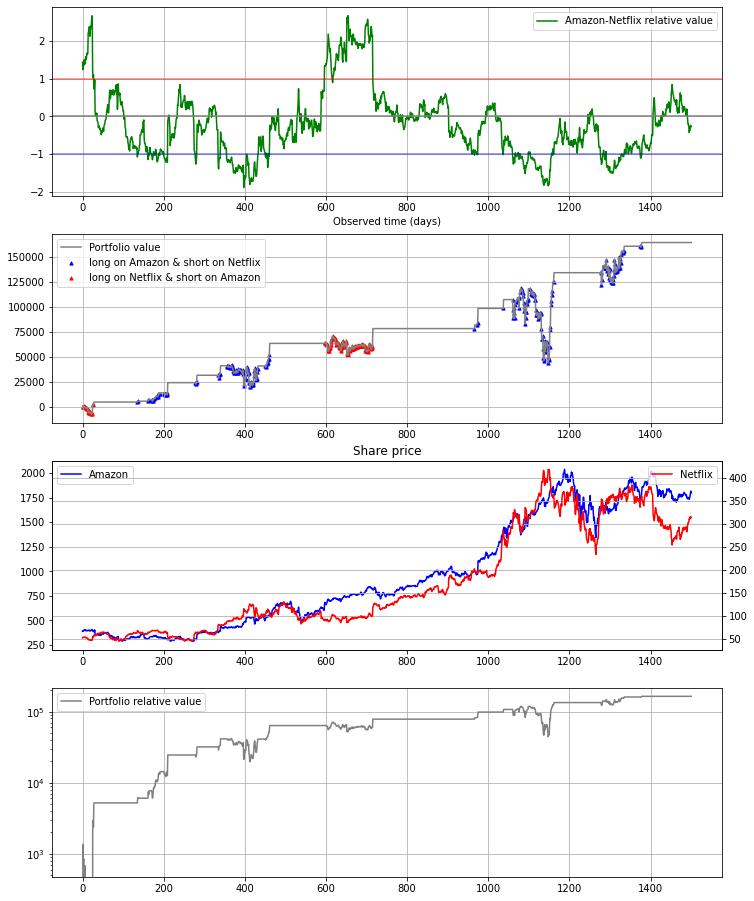

In [ ]:
# Compare relative value between Amazon and Netflix with the positions
plt.figure(figsize=(12,16))

plt.subplot(411)
# Plot relative positions
mean = np.mean(relative_values[:-500])
xplot = np.linspace(0, 1500, len(relative_values))
plt.plot(xplot, relative_values-mean, color='green', label='Amazon-Netflix relative value')
# Plot the edges
plt.axhline(0, color='grey')
plt.axhline(1, color='red', alpha=0.5)
plt.axhline(-1,color='blue', alpha=0.5)
plt.xlabel('Observed time (days)')
plt.grid()
plt.legend()

plt.subplot(412)
color = ['grey', 'blue', 'red']
for key in position_encoding:
  if position_encoding[key] == 'no positions':
    continue
  x=[]
  y=[]
  for i, v in enumerate(position_history):
    if v == key:
      x.append(xplot[i])
      y.append(portfolio_value[i])

  plt.scatter(x, y, color=color[key], label=position_encoding[key], s=10, marker='^')
plt.plot(xplot, portfolio_value, color='grey', label='Portfolio value')
plt.grid()
plt.legend()

plt.subplot(413)
plt.plot(xplot, ts1[-1500:], label='Amazon', color='blue')
plt.legend()
ax2 = plt.twinx()
ax2.plot(xplot, ts2[-1500:], label='Netflix', color='red')
plt.title('Share price')
plt.grid()
plt.legend()

plt.subplot(414)
plt.plot(xplot, portfolio_value, color='grey', label='Portfolio relative value')
plt.yscale('log')
plt.grid()
_ = plt.legend()


There exist 3 moments of where the trader loses money with this strategy:
- Around day 400 with long position in Amazon and short position in Netflix.
- Around day 1100 with long position in Amazon and short position in Netflix.
- Around day 650 with long position in Netflix and short position in Amazon.

Comparing the first two graphs in the previous figure, these moments are unintuitives. 

The moment where the strategy holds a long position in Netflix (around the 650th day) is the one with the greater distance to the parameter frontier in the relative value graph and the smaller valley compared to the others in the portfolio value graph. This can be explained by the difference in each companies' Beta. Amazon has a greater Beta than Netflix, therefore, the impact of its variations are reduced in this strategy. So, when Amazon's price gets rises compared to Netflix's it is dampened.

The second unintuitive moment comes when comparing the two valleys when holding long positions in Amazon. Why does both distances from the parameter frontier in the relative value graph are so similiar and the valley shape of the portfolio value is much deeper at the second operation? The reason for this is that the share price of both companies is much higher in the second moment as shown in the third graph. The fourth graph helps to confirm this theory by demonstrating that in relative terms both "valleys" in the portfolio value are similar.

## Profit Analysis

As observed in the previous subsection for this strategy it is hard to compare the gain/loss observed along the days since the share prices of each company increase.


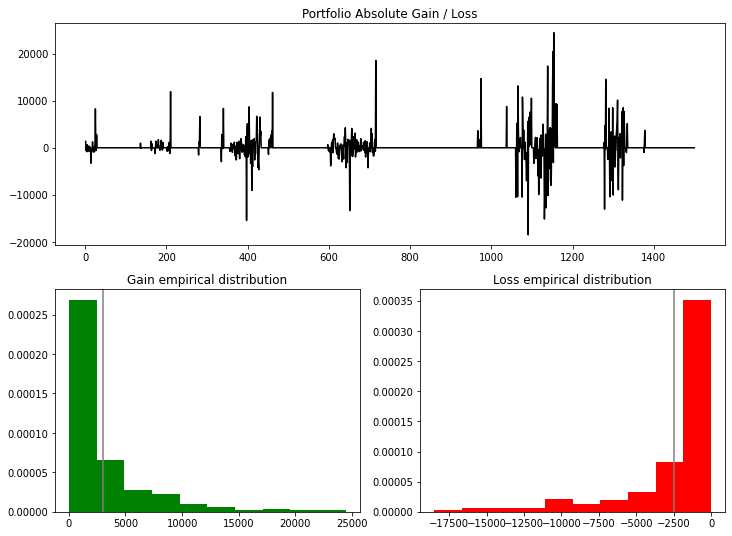

In [ ]:
# Plot absolute gain/loss
gain_loss = np.diff(portfolio_value)
xplot = np.linspace(1,1500,1499)

plt.figure(figsize=(12,9))

plt.subplot(211)
plt.plot(xplot, gain_loss, color='black')
plt.title('Portfolio Absolute Gain / Loss')

plt.subplot(223)
gain = gain_loss[gain_loss>0]
plt.hist(gain, density=True, color='green')
plt.axvline(np.mean(gain), color='grey')
plt.title('Gain empirical distribution')

plt.subplot(224)
loss = gain_loss[gain_loss<0]
plt.hist(loss, density=True, color='red')
plt.axvline(np.mean(loss), color='grey')
_ = plt.title('Loss empirical distribution')

To counterweight this effect I will observe the gains and losses of the portfolio relative to:
- The average price of the shares
- The portfolio's volatility (risk).
- The Beta combined shares volatility.

### Average Share Price Comparison

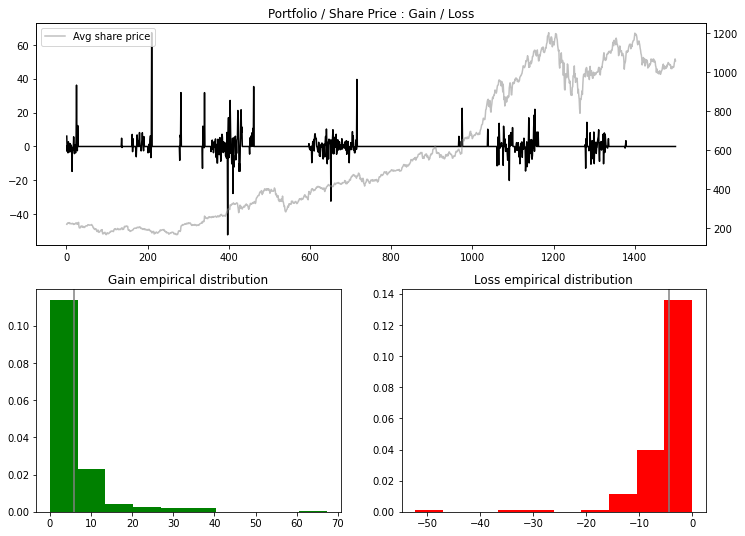

In [ ]:
# Plot price-relative gain/loss
gain_loss = np.diff(portfolio_value)
xplot = np.linspace(1,1500,1499)
avg_price = (ts1+ts2)/2

gain_loss /= avg_price[-1499:]

plt.figure(figsize=(12,9))

plt.subplot(211)
plt.plot(xplot, gain_loss, color='black', label='Relative gain / loss')
plt.title('Portfolio / Share Price : Gain / Loss')
ax2 = plt.twinx()
ax2.plot(xplot, avg_price[-1499:], label='Avg share price', color='grey', alpha=0.5)
plt.legend()

plt.subplot(223)
gain = gain_loss[gain_loss>0]
plt.hist(gain, density=True, color='green')
plt.axvline(np.mean(gain), color='grey')
plt.title('Gain empirical distribution')

plt.subplot(224)
loss = gain_loss[gain_loss<0]
plt.hist(loss, density=True, color='red')
plt.axvline(np.mean(loss), color='grey')
_ = plt.title('Loss empirical distribution')

Interestingly, compared to the source price the gains and losses of the portfolio seem much more stable in the end as opposed to the absolute values.

The gain and the loss distribution kept the same shape but denser around zero this time.

### Portfolio's Risk Comparison

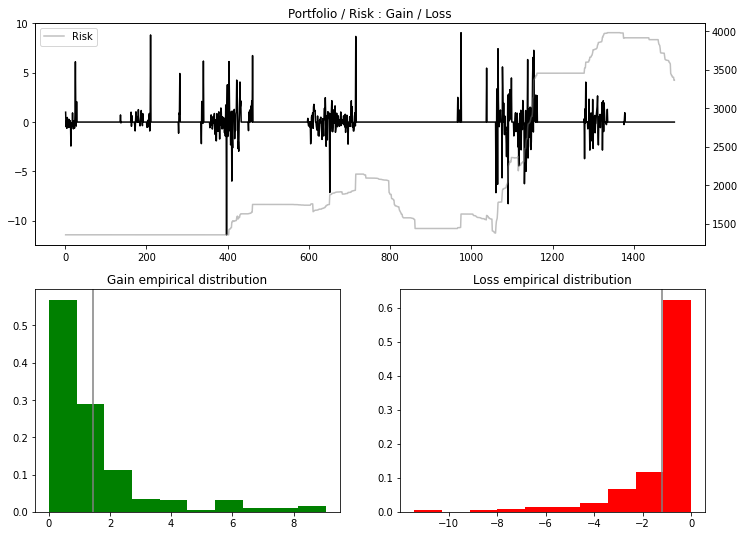

In [ ]:
# Plot price-relative gain/loss
gain_loss = np.diff(portfolio_value)
xplot = np.linspace(1,1500,1499)

ts = pd.Series(gain_loss)
risk = ts.rolling(window=400).std()
for i in range(400):
  risk[i] = risk[400]

gain_loss /= risk

plt.figure(figsize=(12,9))

plt.subplot(211)
plt.plot(xplot, gain_loss, color='black', label='Relative gain / loss')
plt.title('Portfolio / Risk : Gain / Loss')
ax2 = plt.twinx()
ax2.plot(xplot, risk, label='Risk', color='grey', alpha=0.5)
plt.legend()

plt.subplot(223)
gain = gain_loss[gain_loss>0]
plt.hist(gain, density=True, color='green')
plt.axvline(np.mean(gain), color='grey')
plt.title('Gain empirical distribution')

plt.subplot(224)
loss = gain_loss[gain_loss<0]
plt.hist(loss, density=True, color='red')
plt.axvline(np.mean(loss), color='grey')
_ = plt.title('Loss empirical distribution')

This comparison brings a result rather different than the last one. All the variations at the gain/loss graph remain in a similar range when compared to the risk associated with the portfolio's last 400 days results.

This measurement brings some asymmetries to the distributions in the bottom. The gain distribution is denser close to zero and the loss distribution is more sparse.

### Beta-Weighted-Source Volatility Comparison 

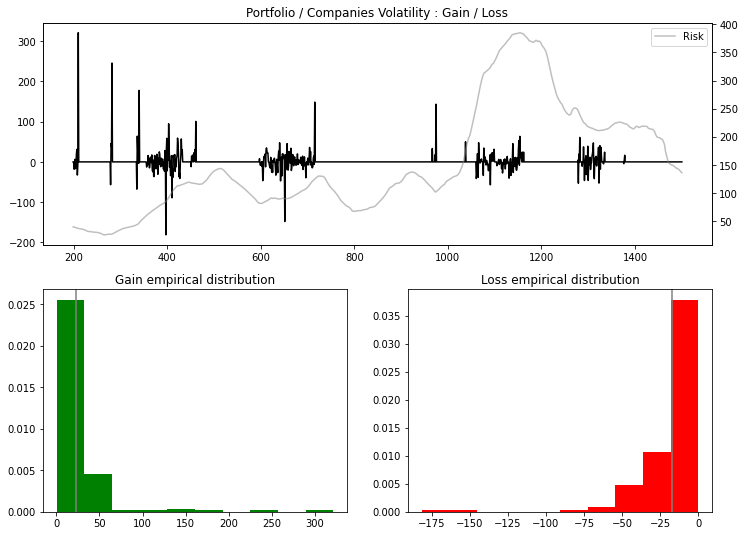

In [ ]:
# Plot price-relative gain/loss
gain_loss = np.diff(portfolio_value)
xplot = np.linspace(1,1500,1499)

ts = pd.Series(beta_amazon*ts1+beta_netflix*ts2)
risk = ts.rolling(window=200).std()
risk = risk[-1499:]

gain_loss /= risk

plt.figure(figsize=(12,9))

plt.subplot(211)
plt.plot(xplot, gain_loss, color='black', label='Relative gain / loss')
plt.title('Portfolio / Companies Volatility : Gain / Loss')
ax2 = plt.twinx()
ax2.plot(xplot, risk, label='Risk', color='grey', alpha=0.5)
plt.legend()

plt.subplot(223)
gain = gain_loss[gain_loss>0]
plt.hist(gain, density=True, color='green')
plt.axvline(np.mean(gain), color='grey')
plt.title('Gain empirical distribution')

plt.subplot(224)
loss = gain_loss[gain_loss<0]
plt.hist(loss, density=True, color='red')
plt.axvline(np.mean(loss), color='grey')
_ = plt.title('Loss empirical distribution')

## Financial Report

This last graph displays an interesting information. Despite the fact that the gains and losses at the beginning seem small in absolute terms compared to the companies volatility those were the highest numbers.

The distributions of gain and loss had the inverse effect as the one observed in the previous analysis.

In [ ]:
print('_________Portfolio report_________\n\n')

print('Final value:           $ %.2F \n' % portfolio_value[-1])

print('Max value:             $ %.2F' % np.max(portfolio_value))
print('Min value:             $ %.2F\n' % np.min(portfolio_value))

print('Expected gain:         $ %.2F' % np.mean(np.diff(portfolio_value)))
print('Max gain:              $ %.2F' % np.max(np.diff(portfolio_value)))
print('Max loss:              $ %.2F\n' % np.min(np.diff(portfolio_value)))

print('Max cumulated loss:    $ %.2F' % np.min([np.min(portfolio_value[i:]) - np.max(portfolio_value[:i]) for i in range(1, len(portfolio_value)-1)]))
print('Volatility (std):      $ %.2F\n' % np.std(np.diff(portfolio_value)))

_________Portfolio report_________


Final value:           $ 164093.49 

Max value:             $ 164093.49
Min value:             $ -7120.42

Expected gain:         $ 109.47
Max gain:              $ 24451.85
Max loss:              $ -18494.20

Max cumulated loss:    $ -74172.79
Volatility (std):      $ 2378.74

